In [55]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice
import pickle

In [50]:
from pytorch_lightning.utilities.model_summary import summarize
from datasets import load_dataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.common import ListDataset
from estimator import TransformerEstimator

In [8]:
dataset = load_dataset("electricity_load_diagrams", "lstnet")

Generating train split:   0%|          | 0/320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2240 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/320 [00:00<?, ? examples/s]

Dataset electricity_load_diagrams downloaded and prepared to /home/kashif/.cache/huggingface/datasets/electricity_load_diagrams/lstnet/1.0.0/fe3dd01c39428ad92523a7ced0df3fdf669cb0548b3dd16fb9f7009381aa440f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
freq = "1H"
prediction_length = 24

In [11]:
train_ds = ListDataset(dataset["train"], freq=freq)

In [12]:
val_ds = ListDataset(dataset["validation"], freq=freq)

In [13]:
test_ds = ListDataset(dataset["test"], freq=freq)

## Sclaing Experiments

We keep the individual layers of the Transformer unchanged: i.e. 
* the model dimension
* the width of the feed-forward layer `dim_feedforward=16`; 
* and the number of attention heads `nhead=2`

We examine the change in the test set metrics as the number of parameters increases with the following three depth scaling approaches:
* Encoder Scaling: vary the `num_encoder_layers` while `num_decoder_layers` is kept fixed
* Decoder Scaling: vary the `num_decoder_layers` while the `num_encoder_layers` is kept fixed
* Symmetric Scaling: vary both the `num_encoder_layers` and `num_decoder_layers` but being equal

In [51]:
layers = [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 48, 56, 64]

### Encoder Scaling

In [ ]:
enc_metrics = []
for layer in layers:
    estimator = TransformerEstimator(
        freq=freq,
        prediction_length=prediction_length,
        context_length=prediction_length*7,

        nhead=2,
        num_encoder_layers=layer,
        num_decoder_layers=6,
        dim_feedforward=16,
        activation="gelu",

        num_feat_static_cat=1,
        cardinality=[320],
        embedding_dimension=[5],

        batch_size=128,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(max_epochs=50, accelerator='auto', gpus=1),
    )
    
    predictor = estimator.train(
        training_data=train_ds,
        validation_data=val_ds,
        num_workers=8,
        shuffle_buffer_length=1024
    )
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds, 
        predictor=predictor
    )
    forecasts = list(forecast_it)
    if layer == layers[0]:
        tss = list(ts_it)
    
    evaluator = Evaluator()
    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))
    agg_metrics["trainable_parameters"] = summarize(estimator.create_lightning_module()).trainable_parameters
    enc_metrics.append(agg_metrics.copy())

In [53]:
enc_metrics_out = open("elec_enc_metrics.pkl", "wb")
pickle.dump(enc_metrics, enc_metrics_out)
enc_metrics_out.close()

Text(0.5, 1.0, 'Encoder Scaling')

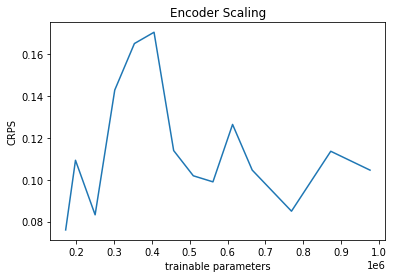

In [66]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in enc_metrics],
    [metrics["mean_wQuantileLoss"] for metrics in enc_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("CRPS")
plt.title("Encoder Scaling")

Text(0.5, 1.0, 'Encoder Scaling')

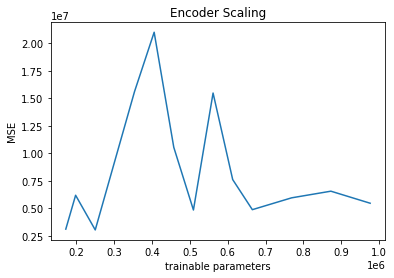

In [68]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in enc_metrics],
    [metrics["MSE"] for metrics in enc_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("MSE")
plt.title("Encoder Scaling")

Text(0.5, 1.0, 'Encoder Scaling')

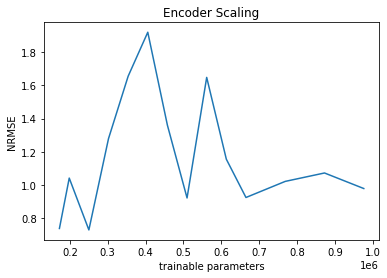

In [79]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in enc_metrics],
    [metrics["NRMSE"] for metrics in enc_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("NRMSE")
plt.title("Encoder Scaling")

### Decoder Scaling

In [ ]:
dec_metrics = []
for layer in layers:
    estimator = TransformerEstimator(
        freq=freq,
        prediction_length=prediction_length,
        context_length=prediction_length*7,

        nhead=2,
        num_encoder_layers=6,
        num_decoder_layers=layer,
        dim_feedforward=16,
        activation="gelu",

        num_feat_static_cat=1,
        cardinality=[320],
        embedding_dimension=[5],

        batch_size=128,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(max_epochs=50, accelerator='auto', gpus=1),
    )
    
    predictor = estimator.train(
        training_data=train_ds,
        validation_data=val_ds,
        num_workers=8,
        shuffle_buffer_length=1024
    )
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds, 
        predictor=predictor
    )
    forecasts = list(forecast_it)
    if layer == layers[0]:
        tss = list(ts_it)
    
    evaluator = Evaluator()
    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))
    agg_metrics["trainable_parameters"] = summarize(estimator.create_lightning_module()).trainable_parameters
    dec_metrics.append(agg_metrics.copy())

In [ ]:
dec_metrics_out = open("elec_dec_metrics.pkl", "wb")
pickle.dump(dec_metrics, dec_metrics_out)
dec_metrics_out.close()

### Symmetric Scaling

In [ ]:
sym_metrics = []
for layer in layers:
    estimator = TransformerEstimator(
        freq=freq,
        prediction_length=prediction_length,
        context_length=prediction_length*7,

        nhead=2,
        num_encoder_layers=layer,
        num_decoder_layers=layer,
        dim_feedforward=16,
        activation="gelu",

        num_feat_static_cat=1,
        cardinality=[320],
        embedding_dimension=[5],

        batch_size=128,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(max_epochs=50, accelerator='auto', gpus=1),
    )
    
    predictor = estimator.train(
        training_data=train_ds,
        validation_data=val_ds,
        num_workers=8,
        shuffle_buffer_length=1024
    )
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds, 
        predictor=predictor
    )
    forecasts = list(forecast_it)
    if layer == layers[0]:
        tss = list(ts_it)
    
    evaluator = Evaluator()
    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))
    agg_metrics["trainable_parameters"] = summarize(estimator.create_lightning_module()).trainable_parameters
    sym_metrics.append(agg_metrics.copy())

In [ ]:
sym_metrics_out = open("elec_sym_metrics.pkl", "wb")
pickle.dump(sym_metrics, sym_metrics_out)
sym_metrics_out.close()